In [1]:
import sys
import math
from collections import defaultdict
from collections import Counter

import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import peakutils
import ltfatpy

from note import Note
import note as notepy
import rion

import pdb


In [8]:
# Interactive inline plots
%matplotlib notebook

In [2]:
# Static inline plots
%matplotlib inline

In [8]:
# Interactive windowed plots
%matplotlib qt

# Helpers

In [10]:
def plot_note_buckets(note_volumes, loud_notes=[], title='Note buckets', notes=None, new_fig=True):
    '''
    Plots note_volumes of notes into a bar graph.
    '''
    if new_fig:
        plt.figure(figsize = (16,4))
        
    if notes == None:
        notes = notepy.note_range(start=Note('A', 0), end=Note('C', 10))

    plt.bar(np.arange(len(note_volumes)), note_volumes)
    plt.plot(loud_notes, np.zeros(len(loud_notes)), 'ro')
    plt.xticks(np.arange(len(notes)), [note.name + str(note.octave) for note in notes], fontsize=7, rotation=90)
    plt.title(title)
    plt.xlabel('Note')
    plt.ylabel('Volume')
    
def clean_note_buckets(note_volumes, noise_volumes, norm_index=None, fs=44100):
    ''' Put x into note buckets, remove noise, normalize '''
    
    if norm_index == None:
        norm_index = np.argmax(note_volumes)
        
    note_volumes = note_volumes - noise_volumes
    note_volumes[note_volumes < 0] = 0
    note_volumes = note_volumes / note_volumes[norm_index]
    
    return note_volumes

def segment_samples(start_note, end_note, input_width, output_width, note_vol_thresh=0.1, output_offset=0, input_offset=1):
    '''
    Segments a recording of multiple samples which are evenly spaced aprart.
    
    Input
        start_note, end_note: the note range
        input_width: the spacing of each sample
        output_width: the amount of each sample to keep
        note_vol_thresh: a threshold to distinguish sound from noise in the range [0,1]
        output_offset: the shift of the output from the location of beginning of the sound
        input_offset: set to 1 if the first sample width is just noise
        
    Output
        note_samples: dict of samples with Note objects as the key
    '''
    note_samples = {}

    for i, note in enumerate(notepy.note_range(start_note, end_note)):
        sample = x[input_width*(i+input_offset) : input_width*(i+input_offset+1)]
        note_start = np.argmax(sample/np.max(sample)>note_vol_thresh) + output_offset
        note_samples[note] = sample[note_start : note_start+output_width]
        
    return note_samples

# Sample Import and Preprocess
In these snippets, we import a sample of a piano playing an Ab3/G\#3, recorded through a phone mic.

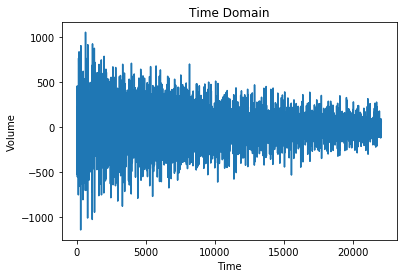

In [4]:
# Load sample
sample_file = 'samples/Intervals_C.wav'
fs, x = scipy.io.wavfile.read(sample_file)
x = x[100000:122050]

plt.plot(x)
plt.title('Time Domain')
plt.xlabel('Time')
plt.ylabel('Volume')

# Load noise sample
noise_sample_file = 'samples/room_noise.wav'
_, x_noise = scipy.io.wavfile.read(noise_sample_file)


# Note Detection
Here, we run a filter on the frequency domain to gather the strength of each note in the timbre.

## Look at Frequency Domain

(0, 5000)

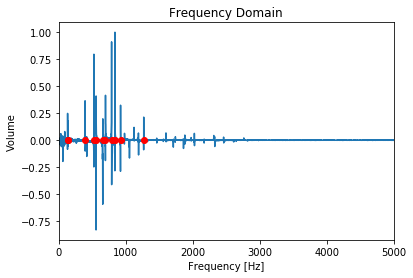

In [5]:
# Take a look at the frequency domain
X = np.real(np.fft.fft(x))
X = X/np.max(X)

peaks = peakutils.indexes(X, thres=0.55/max(X), min_dist=5)

plt.plot(X)
plt.plot(peaks, np.zeros(len(peaks)), 'ro')
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Volume')
plt.xlim([0,5000])


#### Frequency domain stats
Find the peaks in the frequency domain. Those are the notes.

In [6]:
magnitudes, notes = rion.get_notes(x, fs)

print('Notes in timbre, and their magnitudes:')
for magnitude, note, in zip(magnitudes, notes):
    print('{}:\t{:.2f}'.format(note,magnitude))


Notes in timbre, and their magnitudes:
C4+0.02:	0.30
C#4-0.07:	0.17
G5:	0.38
C6+0.02:	1.08
C#6+0.08:	0.39
E6-0.06:	0.36
F6-0.04:	0.38
G6+0.09:	0.57
G#6+0.15:	1.00
Bb6-0.19:	0.21
C#7+0.22:	0.09
Eb7+0.32:	0.21


## Note Buckets
We created a filter which gets the average volume for each note from the frequency domain.

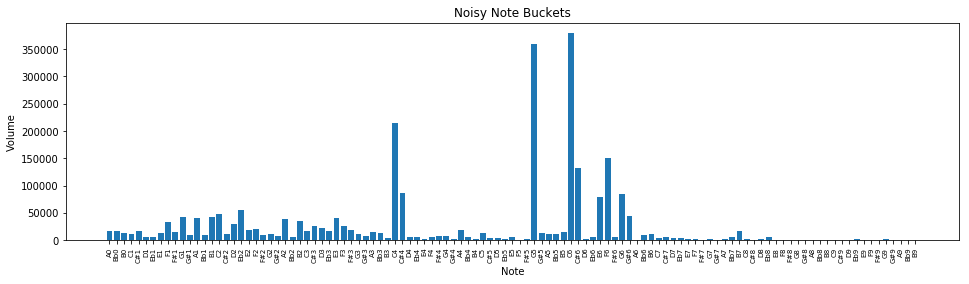

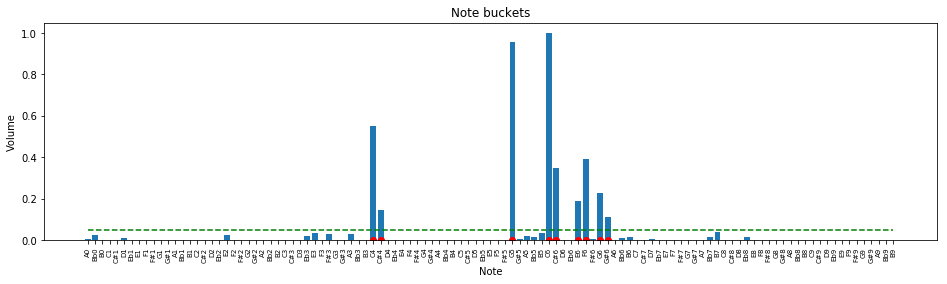

In [7]:
# Put X into note buckets and subtract room noise
# Subtracting noise before bucketing is the same as adding noise
# It either removes the noise or doubles it,
# so we remove noise once we have note volumes
noisy_note_volumes, notes = rion.note_filter(x, fs)
noise_volumes, _    = rion.note_filter(x_noise, fs)
note_volumes = noisy_note_volumes - noise_volumes*0.75
note_volumes[note_volumes < 0] = 0

plot_note_buckets(noisy_note_volumes, title='Noisy Note Buckets')

# Normalize and get octave-normalized note volumes
note_volumes = note_volumes / np.max(note_volumes)
normed_volumes, oct_totals = rion.octave_normalize(note_volumes)
note_names = [note.name + str(note.octave) for note in notes]

# Find loud notes
thresh_val = 0.05
thresh = np.ones(len(note_volumes))*thresh_val
peaks = np.where(note_volumes > thresh)[0]
#peaks = peakutils.indexes(note_volumes, thres=0.02/max(note_volumes), min_dist=1)

plot_note_buckets(note_volumes, peaks)
#plt.bar(np.arange(len(note_volumes)), normed_volumes, alpha=0.25)
plt.plot(thresh, 'g--')


#### Note filter stats
Some statistics that can be gathered from our note filter.


In [8]:
# Get peak notes
peak_notes = [notes[peak] for peak in peaks]
print('Notes in timbre are {}\n'.format([str(peak_note) for peak_note in peak_notes]))
f_0 = peak_notes[0]
print('f_0 is {}\n'.format(f_0))

# Peak tone count
print('Timbre tone count:')
peak_tones = dict(Counter([peak_note.name for peak_note in peak_notes]))
for w in sorted(peak_tones, key=peak_tones.get, reverse=True):
    print('{}\t{}'.format(w, peak_tones[w]))

# Sum of tone strengths
print('\nSum of tone strengths:')
tone_sums = defaultdict(int)
for note, vol in zip(notes, note_volumes):
    tone_sums[note.name] += vol
for w in sorted(tone_sums, key=tone_sums.get, reverse=True):
    print('{}\t{}'.format(w, round(tone_sums[w],3)))


Notes in timbre are ['C4', 'C#4', 'G5', 'C6', 'C#6', 'E6', 'F6', 'G6', 'G#6']

f_0 is C4

Timbre tone count:
C	2
C#	2
G	2
E	1
F	1
G#	1

Sum of tone strengths:
C	1.549
G	1.188
C#	0.495
F	0.39
E	0.244
G#	0.114
B	0.089
Bb	0.062
A	0.061
F#	0.035
Eb	0.032
D	0.015


### Timbre Filter
This is a filter of the timbre of a a note. It has the strength of different harmonics with the 0th index storing the strength of the fundamental frequency, and each following index is a semitone higher.

Todo: test if the timbre of an instrument changes in different octaves.

In [ ]:
# Set semitones which are noise to zero
for i in range(len(note_volumes)):
    if i not in peaks:
        note_volumes[i] = 0

timbre_filter = note_volumes[peaks[0]:peaks[-1]+1]

plt.bar(np.arange(len(timbre_filter)), timbre_filter)
plt.title('Timbre Filter')
plt.xlabel('Pitch (semitones above f_0)')
plt.ylabel('Volume')

# Multiple Note Detection
We can use the note buckets and timbre filter to detect multiple notes.
## Import Samples
Here, we import a sample of a 2-note chord as well as samples of each of the notes being played individually.

(5000, 6000)

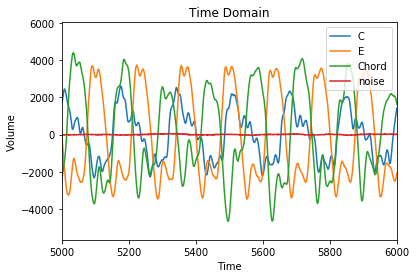

In [12]:
note1 = Note('C', 4)
note2 = Note('E', 4)

input_width = 2*fs # a note is played every input_width seconds
output_width = int(0.5*fs) # we will only use output_width of the sample
note_vol_thresh = 0.1 # vol above thresh is not noise

# Load sample
sample_file = 'samples/chords2_c4.wav'
fs, x = scipy.io.wavfile.read(sample_file)

chrd_samples = segment_samples(Note('C#', 4), Note('C#', 5), input_width, output_width)

# Cut a chord from sample
x_chrd = chrd_samples[note2]

# Load recording of individual notes
sample_file = 'samples/chromatic_c4_eb7.wav'
fs, x = scipy.io.wavfile.read(sample_file)

note_samples = segment_samples(Note('C', 4), Note('E', 7), input_width, output_width)
    
# Assign the notes which we are looking for to variables
x_note1 = note_samples[note1]
x_note2 = note_samples[note2]
x_both  = (x_note1 + x_note2)/2

# Load noise sample
noise_sample_file = 'samples/room_noise.wav'
_, x_noise = scipy.io.wavfile.read(noise_sample_file)

plt.plot(x_note1, label = note1.name)
plt.plot(x_note2, label = note2.name)
plt.plot(x_chrd, label = 'Chord')
plt.plot(x_noise, label='noise')
plt.title('Time Domain')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.xlim((5000,6000))

## Compare frequency domains
Plot the frequency domains of the chord and a signal of the two notes added together.

(0, 2000)

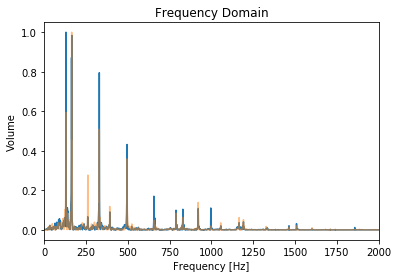

In [13]:
X_chrd = np.real(np.fft.fft(x_chrd))
X_both = np.real(np.fft.fft(x_both))

X_chrd = X_chrd/np.max(X_chrd)
X_both = X_both/np.max(X_both)

plt.plot(np.abs(X_chrd))
plt.plot(np.abs(X_both), alpha=0.5)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Volume')
plt.xlim([0,2000])


Notes in chord are [Note(C4), Note(E4), Note(E5)] with confidence [0.5921627201699409, 0.9987217245986589, 0.9997155489347055]


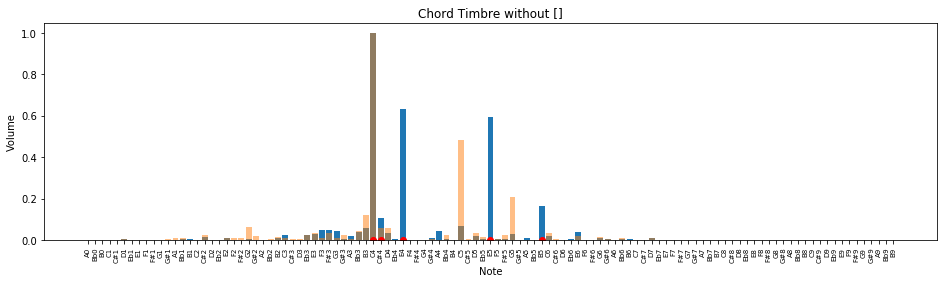

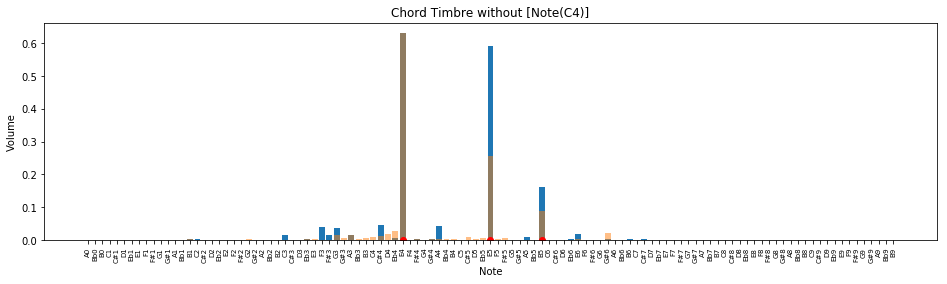

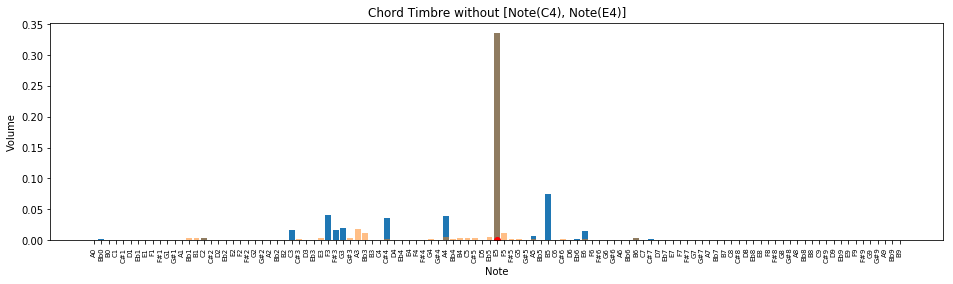

In [19]:
chrd_notes = []
confidences = []

noise_volumes, _    = rion.note_filter(x_noise, fs) # TODO:, noise should look at each note range instead of exact note bucket(s)
chrd_volumes, notes = rion.note_filter(x_chrd, fs)
chrd_volumes = clean_note_buckets(chrd_volumes, noise_volumes, fs=fs)

error_thresh = 0.5
loud_thresh_val = 0.1
loud_thresh = np.ones(len(chrd_volumes))*loud_thresh_val

loud_notes = np.where(chrd_volumes > loud_thresh)[0]

while len(loud_notes) > 0:
    
    plot_note_buckets(chrd_volumes, loud_notes, title='Chord Timbre without {}'.format(chrd_notes))

    # Get first note's timbre
    f0 = notes[loud_notes[0]]
    x_note = note_samples[f0]
    note_volumes, _ = rion.note_filter(x_note)
    note_volumes = clean_note_buckets(note_volumes, noise_volumes, norm_index=notes.index(f0), fs=fs)
    
    plt.bar(np.arange(len(note_volumes)), note_volumes*chrd_volumes[notes.index(f0)], alpha=0.5)
    
    # Subtract first note's timbre from the chord's timbre
    chrd_volumes_less_f0 = chrd_volumes - note_volumes*chrd_volumes[notes.index(f0)]
    
    # Calculate error to determine if note really part of timbre
    y = chrd_volumes_less_f0[notes.index(f0):]
    error = np.sum(np.where(y < 0, y, 0)**2)
    
    if error < error_thresh:
        chrd_notes.append(f0)
        confidences.append((error_thresh-error)/error_thresh)
        chrd_volumes = chrd_volumes_less_f0
        chrd_volumes[chrd_volumes < 0] = 0
    else:
        print('{} failed with error {:.3}'.format(f0, error))
        chrd_volumes[notes.index(f0)] = 0
    
    # Find loud notes
    loud_notes = np.where(chrd_volumes > loud_thresh)[0]
    
print('Notes in chord are {} with confidence {}'.format(chrd_notes, confidences))

# Pitch Detection via Spectrogram (work in progress)

In [ ]:
window = scipy.signal.get_window('triang', 2048)
f, t, Sxx = scipy.signal.spectrogram(x, fs, window=window)
plt.pcolormesh(t, f, Sxx)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
